In [4]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_mass_shootings_in_the_United_States_in_2025'

In [6]:
email = "wella2@byu.edu"
ua = f"STAT386-class-assignment/1.0 (+{email})"

r = requests.get(url, headers={"User-Agent": ua, "From": email}, timeout=15)
r.raise_for_status()

tables = pd.read_html(r.text)

# Sanity check: how many tables did we pull?
print(f"Total tables found: {len(tables)}")

# Select the second table (index 1)
try:
    main_tbl = tables[1]
except IndexError:
    raise RuntimeError("There are fewer than 2 tables on this page — cannot extract the second one.")

print(main_tbl.head())
print(f"Rows: {len(main_tbl)}")
print("Columns:", main_tbl.columns.tolist())

/var/folders/f4/ftsj1j7n5837rlz4_q0rks500000gn/T/ipykernel_46388/4292007148.py:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(r.text)


Total tables found: 5
    2025 date           Location    State or territory Dead Injured  Total  \
0  November 8  San Francisco (4)            California    0       5      5   
1  November 7         Wilmington              Delaware    0       5      5   
2  November 2    Los Angeles (7)            California    0       4      4   
3  November 2         Cincinnati                  Ohio    0       4      4   
4  November 2     Washington (4)  District of Columbia    0       5      5   

                                         Description  
0  A fight in the area of Outer Richmond led to a...  
1  Four men and a woman were shot in the Compton ...  
2  Four men were shot in the Winnetka neighborhoo...  
3  A dispute outside a nightclub in the Over-The-...  
4  Five people were shot in the Gateway neighborh...  
Rows: 385
Columns: ['2025 date', 'Location', 'State or territory', 'Dead', 'Injured', 'Total', 'Description']


In [7]:
# Rename columns for clarity
main_tbl.columns = [
    "Date",
    "City",
    "State or Territory",
    "Deaths",
    "Injuries",
    "Total Victims",
    "Description"
]
main_tbl.head()

,Date,City,State or Territory,Deaths,Injuries,Total Victims,Description
0,November 8,San Francisco (4),California,0,5,5,A fight in the area of Outer Richmond led to a...
1,November 7,Wilmington,Delaware,0,5,5,Four men and a woman were shot in the Compton ...
2,November 2,Los Angeles (7),California,0,4,4,Four men were shot in the Winnetka neighborhoo...
3,November 2,Cincinnati,Ohio,0,4,4,A dispute outside a nightclub in the Over-The-...
4,November 2,Washington (4),District of Columbia,0,5,5,Five people were shot in the Gateway neighborh...


In [8]:
# Rewrite date to be YYYY-MM-DD
main_tbl['Date'] = pd.to_datetime(
    main_tbl['Date'] + " 2025",
    format="%B %d %Y",
    errors='coerce'
)

main_tbl['Date'] = main_tbl['Date'].dt.strftime('%Y-%m-%d')
main_tbl.head()

,Date,City,State or Territory,Deaths,Injuries,Total Victims,Description
0,2025-11-08,San Francisco (4),California,0,5,5,A fight in the area of Outer Richmond led to a...
1,2025-11-07,Wilmington,Delaware,0,5,5,Four men and a woman were shot in the Compton ...
2,2025-11-02,Los Angeles (7),California,0,4,4,Four men were shot in the Winnetka neighborhoo...
3,2025-11-02,Cincinnati,Ohio,0,4,4,A dispute outside a nightclub in the Over-The-...
4,2025-11-02,Washington (4),District of Columbia,0,5,5,Five people were shot in the Gateway neighborh...


In [9]:
# Changing city entries from (City Name (number)) to just City Name and creating a new column for number
main_tbl["City"] = main_tbl["City"].apply(lambda x: re.sub(r" \(\d+\)", "", x))
city_freq = main_tbl["City"].value_counts()
main_tbl["Total City Frequency"] = main_tbl["City"].map(city_freq)

# Reorder columns
cols = main_tbl.columns.tolist()
cols.remove("City")
cols.remove("Total City Frequency")
cols.remove("Date")
new_order = ["Date", "City", "Total City Frequency"] + cols
df = main_tbl[new_order]

# Sort by frequency
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)

df.head()


,Date,City,Total City Frequency,State or Territory,Deaths,Injuries,Total Victims,Description
0,2025-01-01,Kankakee,1,Illinois,2,5,7,Two people were killed and five others were in...
1,2025-01-01,Dallas,7,Texas,1,3,4,An argument in the Wolf Creek neighborhood esc...
2,2025-01-01,New York City,7,New York,0,10,10,Four men opened fire on a queue of people outs...
3,2025-01-01,New Orleans,4,Louisiana,1[n 1],5,6,2025 New Orleans truck attack: A man who was i...
4,2025-01-03,Washington,4,District of Columbia,0,5[n 1],5,A dispute that escalated into a shooting wound...


In [10]:
df["Perpetrator Deaths"] = df["Deaths"].str.contains(r"\[n [12]\]").astype(int)
df["Perpetrator Injuries"] = df["Injuries"].str.contains(r"\[n [12]\]").astype(int)

df["Deaths"] = df["Deaths"].str.replace(r"\s*\[n [123]\]", "", regex=True)
df["Injuries"] = df["Injuries"].str.replace(r"\s*\[n [123]\]", "", regex=True)

df["Deaths"] = pd.to_numeric(df["Deaths"], errors="coerce")
df["Injuries"] = pd.to_numeric(df["Injuries"], errors="coerce")

df.rename(columns={
    "Deaths": "Total Deaths",
    "Injuries": "Total Injuries"
}, inplace=True)

cols = df.columns.tolist()

cols.insert(cols.index("Total Deaths") + 1, cols.pop(cols.index("Perpetrator Deaths")))
cols.insert(cols.index("Total Injuries") + 1, cols.pop(cols.index("Perpetrator Injuries")))

df = df[cols]


df.head()


,Date,City,Total City Frequency,State or Territory,Total Deaths,Perpetrator Deaths,Total Injuries,Perpetrator Injuries,Total Victims,Description
0,2025-01-01,Kankakee,1,Illinois,2,0,5,0,7,Two people were killed and five others were in...
1,2025-01-01,Dallas,7,Texas,1,0,3,0,4,An argument in the Wolf Creek neighborhood esc...
2,2025-01-01,New York City,7,New York,0,0,10,0,10,Four men opened fire on a queue of people outs...
3,2025-01-01,New Orleans,4,Louisiana,1,1,5,0,6,2025 New Orleans truck attack: A man who was i...
4,2025-01-03,Washington,4,District of Columbia,0,0,5,1,5,A dispute that escalated into a shooting wound...


In [26]:
# Information regarding final dataset
df.info()
# Total sample size
print(f"Total number of shootings recorded: {len(df)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  384 non-null    object 
 1   City                  385 non-null    object 
 2   Total City Frequency  385 non-null    int64  
 3   State or Territory    385 non-null    object 
 4   Total Deaths          385 non-null    int64  
 5   Perpetrator Deaths    385 non-null    int64  
 6   Total Injuries        385 non-null    int64  
 7   Perpetrator Injuries  385 non-null    int64  
 8   Total Victims         385 non-null    int64  
 9   Description           385 non-null    object 
 10  Month                 384 non-null    float64
dtypes: float64(1), int64(6), object(4)
memory usage: 33.2+ KB
Total number of shootings recorded: 385


In [11]:
# Summary statistics
total_shootings = len(df)
total_deaths = df['Total Deaths'].sum()
total_injuries = df['Total Injuries'].sum()
average_victims = df['Total Victims'].mean()

print(f"Total Shootings: {total_shootings}")
print(f"Total Deaths: {total_deaths}")
print(f"Total Injuries: {total_injuries}")
print(f"Average Victims per Shooting: {average_victims:.2f}")

Total Shootings: 385
Total Deaths: 375
Total Injuries: 1723
Average Victims per Shooting: 5.45


In [36]:
# Export cleaned dataset to CSV
df.to_csv("mass_shootings_2025.csv", index=False)

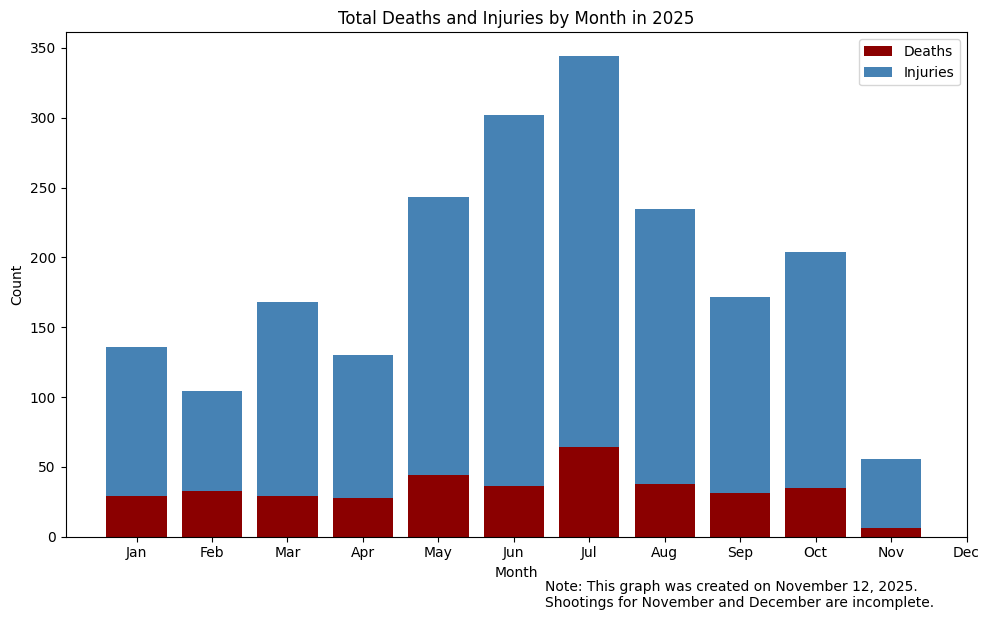

In [ ]:
# This plot shows total shootings by month in 2025, with deaths and injuries stacked.

import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
df['Month'] = pd.to_datetime(df['Date']).dt.month
monthly = df.groupby('Month')[['Total Deaths', 'Total Injuries']].sum().reset_index()

# Plot stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot deaths
ax.bar(monthly['Month'], monthly['Total Deaths'], color='DarkRed', label='Deaths')

# Plot injuries on top
ax.bar(monthly['Month'], monthly['Total Injuries'], 
       bottom=monthly['Total Deaths'], color='SteelBlue', label='Injuries')

# Labels and title
ax.set_title('Total Deaths and Injuries by Month in 2025')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.legend()

# Note below plot
plt.figtext(0.55, -0.02,
            "Note: This graph was created on November 12, 2025.\nShootings for November and December are incomplete.")

plt.tight_layout()
plt.show()

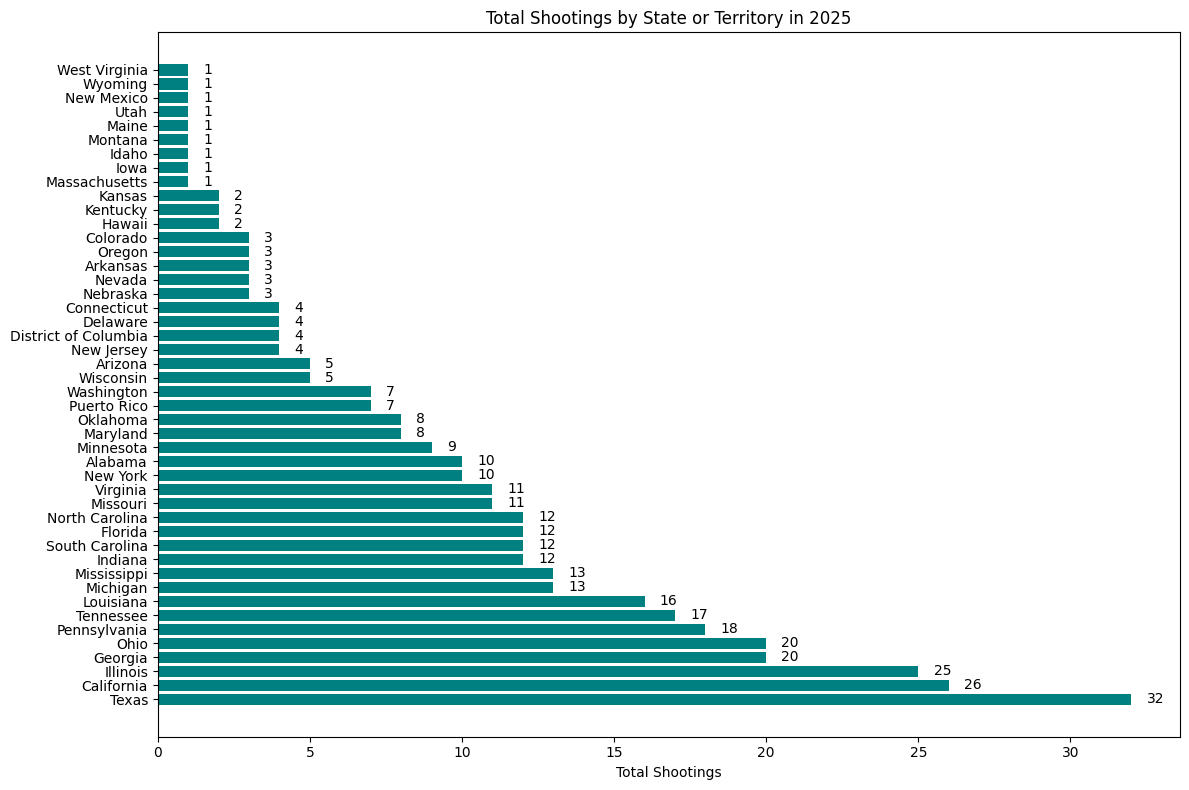

In [ ]:
# This plot shows total shootings by state

# Example: your state counts
state_counts = df['State or Territory'].value_counts().reset_index()
state_counts.columns = ['State or Territory', 'Total Shootings']

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(state_counts['State or Territory'], state_counts['Total Shootings'], color='teal')

# Add numbers at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,  # x-position, y-position
            f'{int(width)}', va='center', ha='left', fontsize=10)

# Labels and title
ax.set_xlabel('Total Shootings')
ax.set_title('Total Shootings by State or Territory')
plt.tight_layout()
plt.show()


In [41]:
# How many shootings involved perpetrators who died or were injured?
perp_deaths = df['Perpetrator Deaths'].sum()
perp_injuries = df['Perpetrator Injuries'].sum()

print(f"Total Shootings with Perpetrator Deaths: {perp_deaths}")
print(f"Total Shootings with Perpetrator Injuries: {perp_injuries}")

print(f"Total Percentage of Shootings with Perpetrator Deaths: {perp_deaths / len(df) * 100:.2f}%")
print(f"Total Percentage of Shootings with Perpetrator Injuries: {perp_injuries / len(df) * 100:.2f}%")


Total Shootings with Perpetrator Deaths: 32
Total Shootings with Perpetrator Injuries: 10
Total Percentage of Shootings with Perpetrator Deaths: 8.31%
Total Percentage of Shootings with Perpetrator Injuries: 2.60%


In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Count total shootings per state
state_counts = df['State or Territory'].value_counts().reset_index()
state_counts.columns = ['State', 'Total Shootings']

# Load US states shapefile
shapefile_path = "path_to_shapefile/cb_2018_us_state_5m.shp"
us_states = gpd.read_file(shapefile_path)

# Keep only the 50 states + DC (remove territories if you want)
us_states = us_states[us_states['STUSPS'].isin([
    'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA',
    'HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
    'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
    'NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
    'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY','DC'
])]

# Merge shootings data
# Note: us_states has state abbreviation 'STUSPS'; if your df has full state names, convert them
state_abbrev = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA',
    'Colorado':'CO','Connecticut':'CT','Delaware':'DE','Florida':'FL','Georgia':'GA',
    'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS',
    'Kentucky':'KY','Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA',
    'Michigan':'MI','Minnesota':'MN','Mississippi':'MS','Missouri':'MO','Montana':'MT',
    'Nebraska':'NE','Nevada':'NV','New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM',
    'New York':'NY','North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK',
    'Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC','South Dakota':'SD',
    'Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT','Virginia':'VA','Washington':'WA',
    'West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY','District of Columbia':'DC'
}

state_counts['STUSPS'] = state_counts['State'].map(state_abbrev)

# Merge with shapefile
us_states = us_states.merge(state_counts, how='left', on='STUSPS')

# Fill NaN with 0 for states with no shootings
us_states['Total Shootings'] = us_states['Total Shootings'].fillna(0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15,10))
us_states.plot(column='Total Shootings', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title("Mass Shootings by State in 2025", fontsize=18)
ax.axis('off')
plt.show()




DataSourceError: path_to_shapefile/cb_2018_us_state_5m.shp: No such file or directory